
### Reglas generales del modelo
-   Dos nonine no pueden ocupar la misma sección.
-   Dos deddian no pueden ocupar la misma sección.
-   Cada nonine solo puede comer hierba si no ha llegado a su máxima capacidad de comida.
-   Un deddian no se comerá un nonine si ha sobrepasado su capacidad máxima de comida.
-   Nonines y deddians solo puede reproducirse cuando han llegado a cierta edad y ha logrado una cierta capacidad de cimida.
-   Un nonine no puede reproducirse si hay un deddian a su alrededor.
-   Nonines y deddians solo pueden mover hacia arriba, abajo, izquierda o derecha de su posición actual.
-   Nonines y deddians mueren si son muy viejos o si no han comido lo suficiente.
-   La hierba tiene una tasa de crecimiento de 1 unidad/ciclo.

### Reglas para los nonine
-   Capacidad máxima de comida: 45 unidades.
-   Tasa de metabolismo: 3 unidades/ciclo.
-   Probilidad de reproducción en un ambiente adecuada: 50%
-   Edad mínima de reproducción: 10 ciclos.
-   Requisito mínimo de alimento para reproducirse: 40 unidades.
-   Edad máxima: 25 etapas.
-   Comida inicial: 10
-   Un nonine le da un valor de comida de 10 a un deddian cuando se lo come.

En cada ciclo,
-   Un nonine se mueve aleatoriamente a uno de los cuatro campos vecinos, siempre que esté vacío (no existe otro nonine o deddian). Este movimiento le consume una cierta cantidad de la comida que ha ingerido. Si no hay celdas vecinas libres, no se produce movimiento.
-   Si no ha llegado a su capacidad máxima de comida, consumirá toda lo que hay en ese campo (hasta el límite definido).
-   Al superar su tiempo de reproducción predefidino, el nonine dará a a luz un nuevo nonine siempre y cuando tenga la energía necesaria y esté en un ambiente adecuado. El nuevo nonine se deberá generar en una celda vecina vacía. Si no se cumple alguno de estos requisitos, no se generará ningún nuevo nonine.

### Reglas para los deddian

-   Capacidad máxima de comida: 200 unidades.
-   Tasa de metabolismo: 2 unidades/ciclo.
-   Probilidad de reproducción en un ambiente adecuada: 50%
-   Edad mínima de reproducción: 10 ciclos.
-   Requisito mínimo de alimento para reproducirse: 120 unidades.
-   Edad máxima: 50 etapas.
-   Comida inicial: 150

En cada ciclo,

-   Un deddian se mueve aleatoriamente a uno de los cuatro campos vecinos, siempre que no haya otro deddian. Este movimiento le consume una cierta cantidad de la comida que ha ingerido. Si no hay celdas vecinas libres de deddians, no se produce movimiento.
-   Si se encuentra con un nonine y no ha sobrepasado su capacidad máxima, se lo comerá. Obteniendo una cantidad de energía definida.
-   Al superar su tiempo de reproducción predefidino, el deddian dará a a luz un nuevo deddian siempre y cuando tenga la energía necesaria y esté en un ambiente adecuado. El nuevo deddian se deberá generar en una celda vecina vacía. Si no se cumple alguno de estos requisitos, no se generará ningún nuevo deddian.

## Condiciones de simulación
-   El planeta tenga un ancho y alto de 35 celdas.
-   Inicialmente, habrá 47 nonines y 15 deddians.
-   Todos los campos empiezan con 20 unidades de hierba.
-   La simulación se realizará durante 200 iteraciones.
-   Deberá visualizar la evolución del modelo.

In [23]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivationByType

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [24]:
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for (content, x, y) in model.grid.coord_iter():
        if content == None:
            grid[x][y] = model.floor[x][y]
        else:
            grid[x][y] = content.species
    return grid

In [25]:
class NonineAgent(Agent):
    def __init__(self, unique_id, model, max_food = 45, metabolism = 3, reproduction_rate = 0.5, 
                 min_age_reproduction = 10, min_food_reproduction = 40, max_age = 25, initial_food = 10, species = 150):
        super().__init__(unique_id, model)
        self.max_food = max_food
        self.metabolism = metabolism
        self.reproduction_rate = reproduction_rate
        self.min_age_reproduction = min_age_reproduction
        self.min_food_reproduction = min_food_reproduction
        self.max_age = max_age
        self.initial_food = initial_food
        self.current_food = initial_food
        self.current_age = 1
        self.species = species
        self.can_reproduce = False
        self.baby_pos = ()
        
    def step(self):
        self.current_age += 1
        self.current_food -= self.metabolism
        available_cells = []
        move_to_cell = 0
        neighborhood = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False, radius=1)
        total_nonines = 0
        total = 0
        neighbors = self.model.grid.get_neighbors(self.pos, moore=False, include_center=False, radius=1)
        deddians_close = False
             
        if self.current_age >= self.max_age or self.current_food <= 0:
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            return
        
        if self.model.floor[self.pos[0]][self.pos[1]] >= 1:
            self.current_food += self.model.grass_hunger
            self.model.floor[self.pos[0]][self.pos[1]] -= self.model.grass_hunger
            
        for neighbor in neighbors:
            if type(neighbor) is not type(self):
                deddians_close = True
                break
        
        for cell in neighborhood:
            if self.model.grid.is_cell_empty(cell):
                available_cells.append(cell)
        
        if self.current_age >= self.min_age_reproduction and self.current_food >= self.min_food_reproduction:
            will_reproduce = self.random.randint(0, 1)
            if deddians_close == False and len(available_cells) > 0 and will_reproduce == 1:
                #new_nonine = NonineAgent(self.unique_id, self.model)
                self.can_reproduce = True
                new_nonine_pos = available_cells[self.random.randint(0, len(available_cells) - 1)]
                self.baby_pos = new_nonine_pos
                available_cells.remove(new_nonine_pos)
                
        if len(available_cells) > 0: 
                move_to_cell = self.random.randint(0, len(available_cells) - 1)
                self.model.grid.move_agent(self, available_cells[move_to_cell])     

In [26]:
# Verificar lógica para la reproducción de deddian y nonine, siguen reproduciendose aun cuando pasa 
#la comida del deddian/nonine
class DeddianAgent(Agent):
    def __init__(self, unique_id, model, max_food = 200, metabolism = 2, reproduction_rate = 0.5, 
                 min_age_reproduction = 10, min_food_reproduction = 120, max_age = 50, initial_food = 150, species = 200):
        super().__init__(unique_id, model)
        self.max_food = max_food
        self.metabolism = metabolism
        self.reproduction_rate = reproduction_rate
        self.min_age_reproduction = min_age_reproduction
        self.min_food_reproduction = min_food_reproduction
        self.max_age = max_age
        self.initial_food = initial_food
        self.current_food = initial_food
        self.current_age = 1
        self.species = species
        self.can_reproduce = False
        self.baby_pos = ()
        
    def step(self):
        #print("deddian:", self.unique_id)
        self.current_age += 1
        self.current_food -= self.metabolism
        available_cells = []
        neighborhood = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False, radius=1)
        neighbors = self.model.grid.get_neighbors(self.pos, moore=False, include_center=False, radius=1)
        close_nonines = []
        
        if self.current_age >= self.max_age or self.current_food <= 0:
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            return
        
        for cell in neighborhood:
            if self.model.grid.is_cell_empty(cell):
                available_cells.append(cell)
                
        for neighbor in neighbors:
            if type(neighbor) is not type(self):
                close_nonines.append(neighbor)
                
        
        if self.current_age >= self.min_age_reproduction and self.current_food >= self.min_food_reproduction:
            will_reproduce = self.random.randint(0, 1)
            if len(available_cells) > 0 and will_reproduce == 1:
                #self.current_food -= self.min_food_reproduction
                new_deddian_pos = available_cells[self.random.randint(0, len(available_cells) - 1)]
                self.can_reproduce = True
                self.baby_pos = new_deddian_pos
                available_cells.remove(new_deddian_pos)
                
        if len(available_cells) + len(close_nonines) > 0 and self.current_food >= self.metabolism:
            if len(close_nonines) > 0 and self.current_food <= self.max_food:
                self.current_food += self.model.nonine_hunger
                self.current_food -= self.metabolism
                randomNonine = close_nonines[self.random.randint(0, len(close_nonines) - 1)]
                new_pos = randomNonine.pos
                self.model.grid.remove_agent(randomNonine)
                self.model.schedule.remove(randomNonine)
                self.model.grid.move_agent(self, new_pos)
            elif len(available_cells) > 0 and (len(close_nonines) <= 0 or self.current_food > self.max_food):
                new_pos = available_cells[self.random.randint(0, len(available_cells) - 1)]
                self.model.grid.move_agent(self, new_pos)

In [32]:
class CenituneModel(Model):
    def __init__(self, width, height, num_grass = 20, num_nonines = 47, num_deddians = 15):
        self.num_grass = num_grass
        self.num_nonines = num_nonines
        self.num_deddians = num_deddians
        self.grass_hunger = 5
        self.nonine_hunger = 10
        self.grid = SingleGrid(width, height, False)
        self.schedule = RandomActivationByType(self)
        self.floor = np.full((width, height), num_grass)
        self.grass_coords_x = []
        self.grass_coords_y =[]
        self.agent_count = 0
        
        id = 0
        
        for i in range(self.num_nonines):
            nonine = NonineAgent(id, self)
            (x, y) = self.grid.find_empty()
            self.grid.place_agent(nonine, (x, y))
            self.schedule.add(nonine)
            id += 1
        
        for i in range(self.num_deddians):
            deddian = DeddianAgent(id, self)
            (x, y) = self.grid.find_empty()
            self.grid.place_agent(deddian, (x, y))
            self.schedule.add(deddian)
            id += 1
        
        self.agent_count = id
        self.datacollector = DataCollector(model_reporters={"Grid":get_grid})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step_type(NonineAgent)        
        for (content, x, y) in self.grid.coord_iter():
            if content != None and content.can_reproduce == True and content.species == 150:
                nonine = NonineAgent(self.agent_count, self)
                if self.grid.is_cell_empty(content.baby_pos):
                    self.grid.place_agent(nonine, content.baby_pos)
                    self.schedule.add(nonine)
                    self.agent_count += 1 

        self.schedule.step_type(DeddianAgent)    
        for (content, x, y) in self.grid.coord_iter():
            if content != None and content.can_reproduce == True and content.species == 200:
                deddian = DeddianAgent(self.agent_count, self)
                if self.grid.is_cell_empty(content.baby_pos):
                    self.grid.place_agent(deddian, content.baby_pos)
                    self.schedule.add(deddian)
                    self.agent_count += 1

        finished = False        
        for i in range(self.grid.width):
            for j in range(self.grid.height):
                if self.floor[i][j] < 20:
                    self.floor[i][j] += 1

In [33]:
MAX_ITERATIONS = 200
WIDTH = 35
HEIGHT = 35

start_time = time.time()
model = CenituneModel(WIDTH, HEIGHT, 20, 47, 15)
for i in range(MAX_ITERATIONS):
    model.step()
        
print('Tiempo de ejecución: ', str(datetime.timedelta(seconds=(time.time() - start_time))))


Tiempo de ejecución:  0:00:01.979078


In [34]:
all_grid = model.datacollector.get_model_vars_dataframe()
print(all_grid)

                                                  Grid
0    [[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 200.0, 2...
1    [[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20...
2    [[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 200.0, 2...
3    [[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20...
4    [[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 200.0, 2...
..                                                 ...
195  [[200.0, 200.0, 200.0, 20.0, 200.0, 200.0, 200...
196  [[200.0, 200.0, 20.0, 200.0, 20.0, 200.0, 200....
197  [[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 20...
198  [[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 20...
199  [[200.0, 200.0, 20.0, 200.0, 200.0, 200.0, 200...

[200 rows x 1 columns]


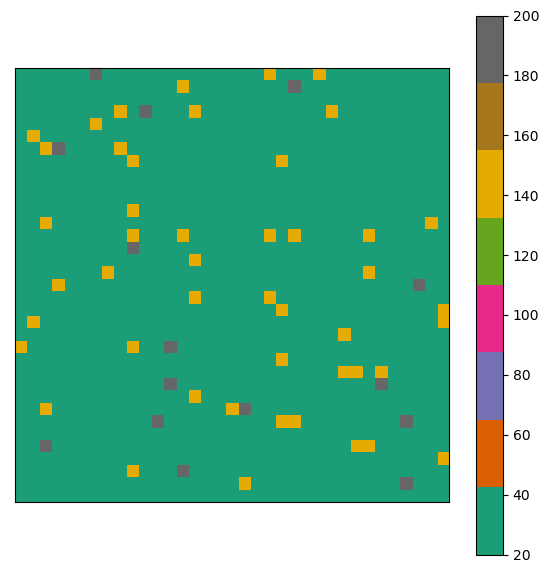

In [35]:
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.Dark2, )
fig.colorbar(patch, ax=axs)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=MAX_ITERATIONS)

In [36]:
# 200 = Deddian
# 150 = Nonine
anim